In [110]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [174]:
# 创建映射字典
label_number = {'装': 1, '卸': -1}

# 定义一个函数，用于将Category列的文本转换为对应数值
def label_to_number(row):
    v=row['state']
    if v not in label_number:
        return 0
    return label_number[v]
def number_to_label(row):
    v=row['state'].strip()
    display(v)
    if v ==1:
        return '装'
    elif v == -1:
        return '卸'
    else:
        return '-'
    
dfstate =pd.read_csv('./data/states.txt')
dfstate['start'] =dfstate.apply(lambda row:row['date']+' '+row['start_time'],axis=1)
dfstate['end'] = dfstate.apply(lambda row:row['date']+' '+row['end_time'],axis=1)
dfstate['state']=dfstate['state'].str.strip()
dfstate[['start','end']]=dfstate[['start','end']].apply(pd.to_datetime)
dfstate['statev'] = dfstate.apply(label_to_number,axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv('./data/states.csv')
dfstate

,date,start_time,end_time,state,start,end,statev
0,2023-12-17,10:44:49,10:48:59,装,2023-12-17 10:44:49,2023-12-17 10:48:59,1
1,2023-12-17,11:29:45,11:31:55,卸,2023-12-17 11:29:45,2023-12-17 11:31:55,-1
2,2023-12-17,12:23:56,12:29:44,装,2023-12-17 12:23:56,2023-12-17 12:29:44,1
3,2023-12-17,12:55:08,12:56:28,卸,2023-12-17 12:55:08,2023-12-17 12:56:28,-1
4,2023-12-17,13:45:02,13:45:42,装,2023-12-17 13:45:02,2023-12-17 13:45:42,1
5,2023-12-17,14:18:27,14:19:47,卸,2023-12-17 14:18:27,2023-12-17 14:19:47,-1
6,2023-12-17,14:59:59,15:03:59,装,2023-12-17 14:59:59,2023-12-17 15:03:59,1
7,2023-12-17,15:32:25,15:35:45,卸,2023-12-17 15:32:25,2023-12-17 15:35:45,-1
8,2023-12-17,16:18:03,16:22:03,装,2023-12-17 16:18:03,2023-12-17 16:22:03,1
9,2023-12-17,16:55:15,16:58:01,卸,2023-12-17 16:55:15,2023-12-17 16:58:01,-1


In [178]:
# 定义读取，处理数据函数
def fix_data(inputDF:pd.DataFrame)->pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0,'label','other')
    inputDF.insert(0,'state',0)
 
    
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate['start'] <= row['时间']) & (row['时间'] <= dfstate['end'])
        match = dfstate[condition]
        
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, 'state'] = match['statev'].values[0]
            inputDF.at[index, 'label'] = match['state'].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为0）
            pass    
    return inputDF

def read_data(file_path:str)->pd.DataFrame:
    return fix_data( pd.read_excel(file_path,engine='openpyxl',parse_dates=['时间','轨迹时间']))

In [179]:

#读取数据
df1 =read_data("./data/data_17.xlsx")
df21 =read_data("./data/data_21.xlsx")
df22 =read_data("./data/data_22.xlsx")
df23 =read_data("./data/data_23.xlsx")

# df1=pd.read_csv('data.csv') 
 
# df1=df1.iloc[:,2:]
# df1.tail(),'rows',len(df1)

In [180]:
# df1.info() 
display(df1.shape,df21.shape,df22.shape,df23.shape)
len(df1.query('state != 0')),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0'))
 
display( df1.query('state != 0'),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0')))


(16530, 30)

(24964, 26)

(27913, 26)

(27942, 30)

,state,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
1251,1,装,2023-12-17 10:44:51,2917,0,2917,32506,12584,-3878,76807,...,0,0,0,2023-12-17 10:45:00,0,0,108.825000,0.000000,0.439861,0.000000
1252,1,装,2023-12-17 10:44:54,3006,0,4832,32334,12565,-3495,76933,...,0,-226,165,2023-12-17 10:45:00,0,0,48.216667,0.000000,-0.574931,0.000000
1253,1,装,2023-12-17 10:44:56,-8071,0,-5433,33256,12539,-4495,76521,...,66,121,-242,2023-12-17 10:45:00,0,0,-84.608333,0.000000,-2.001667,0.000000
1254,1,装,2023-12-17 10:44:59,-10109,0,-8060,33492,12764,-3675,76653,...,-149,-1093,940,2023-12-17 10:45:00,0,0,4.358333,0.000000,-0.379653,0.000000
1255,1,装,2023-12-17 10:45:03,-25818,0,-23258,34857,13436,-4805,75648,...,-516,-176,483,2023-12-17 10:45:10,0,0,-189.916667,0.000000,-2.518194,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8166,-1,卸,2023-12-17 16:57:46,36340,36940,37564,29394,13073,-118,76892,...,11,17,-55,2023-12-17 16:57:51,0,36040,-5.375000,-1.583333,-0.647083,-0.871181
8167,-1,卸,2023-12-17 16:57:50,38544,36940,39446,29225,13225,-1,76762,...,6,49,-16,2023-12-17 16:57:51,0,36040,12.800000,-1.541667,-0.510347,-0.870486
8168,-1,卸,2023-12-17 16:57:53,38511,36940,38578,29303,13286,-95,76702,...,5,16,-11,2023-12-17 16:58:02,0,36040,10.208333,-1.541667,-0.548125,-0.870486
8169,-1,卸,2023-12-17 16:57:56,36073,36940,36930,29451,13083,-245,76894,...,-5,11,-17,2023-12-17 16:58:02,0,36040,-9.091667,-1.541667,-0.672708,-0.870486


340

845

1420

In [145]:
#进行数据归一化
from sklearn import preprocessing

# 初始化 MinMaxScaler 对象
min_max_scaler = preprocessing.MinMaxScaler()

# df0=min_max_scaler.fit_transform(df1)
# df = pd.DataFrame(df0, columns=df1.columns)
# input_size=len(df.iloc[1,:])


# 假设我们有一个DataFrame df，并且希望对其中的所有数值列进行标准化
# 先提取出所有数值列
numeric_features = df1.select_dtypes(include=[np.number]).columns.tolist()

# 使用 fit() 方法计算最小值和最大值（训练集上）
# min_max_scaler.fit(df1[numeric_features])
df0=min_max_scaler.fit_transform(df1[numeric_features])
# 使用 transform() 方法对数据进行标准化
df = pd.DataFrame(df0, columns=numeric_features, index=df1.index)
input_size=len(df.iloc[1,:])
display(df1.head())
display(df.head())
display(input_size,df.shape)

,state,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,0,2023-12-17 09:39:23,-4063,2020,-4375,33161,13662,326,76328,1867,...,0,0,0,2023-12-17 09:39:28,0,0,0.0,0.0,0.0,0.0
1,0,2023-12-17 09:39:26,-4175,2020,-4364,33160,13636,327,76355,1867,...,0,0,0,2023-12-17 09:39:28,0,0,0.0,0.0,0.0,0.0
2,0,2023-12-17 09:39:30,-4575,2020,-4486,33171,13649,312,76342,1867,...,0,5,5,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0
3,0,2023-12-17 09:39:32,-4330,2020,-4397,33163,13649,314,76342,1867,...,0,6,6,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0
4,0,2023-12-17 09:39:35,-4442,2020,-4475,33170,13648,314,76343,1873,...,6,-6,-11,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0


,state,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,...,wpu_z_diff,su_x_diff,su_y_diff,su_z_diff,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,0.5,0.232819,0.054338,0.240478,0.759523,0.448481,0.447189,0.597489,0.658491,0.488465,...,0.516595,0.545150,0.562713,0.535442,0.0,0.0,0.551645,0.617416,0.592099,0.5
1,0.5,0.232163,0.054338,0.240551,0.759450,0.447368,0.447231,0.598713,0.658491,0.488465,...,0.517967,0.545150,0.562713,0.535442,0.0,0.0,0.551645,0.617416,0.592099,0.5
2,0.5,0.229822,0.054338,0.239745,0.760259,0.447925,0.446601,0.598123,0.658491,0.488689,...,0.515934,0.545150,0.562959,0.535512,0.0,0.0,0.551645,0.617416,0.592099,0.5
3,0.5,0.231256,0.054338,0.240333,0.759671,0.447925,0.446685,0.598123,0.658491,0.488958,...,0.516595,0.545150,0.563009,0.535526,0.0,0.0,0.551645,0.617416,0.592099,0.5
4,0.5,0.230600,0.054338,0.239818,0.760185,0.447882,0.446685,0.598169,0.658734,0.488689,...,0.516645,0.545351,0.562417,0.535288,0.0,0.0,0.551645,0.617416,0.592099,0.5


27

(16530, 27)

In [148]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 32
dropout = 0.01
epoch=60

#构建lstm输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.values #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

df.values[3:5]

(14872, 5, 27) (14872,) (1652, 5, 27) (1652,)


array([[0.5       , 0.23125589, 0.05433759, 0.24033317, 0.75967054,
        0.44792469, 0.44668515, 0.59812322, 0.65849118, 0.48895758,
        0.97351846, 0.51213147, 0.61741601, 0.48177059, 0.51822826,
        0.49747007, 0.46678784, 0.51659466, 0.54515005, 0.56300863,
        0.53552554, 0.        , 0.        , 0.5516445 , 0.61741601,
        0.59209949, 0.5       ],
       [0.5       , 0.23060041, 0.05433759, 0.23981796, 0.76018532,
        0.4478819 , 0.44668515, 0.59816855, 0.65873401, 0.4886888 ,
        0.97326091, 0.51002344, 0.61741601, 0.48072101, 0.51927787,
        0.49741997, 0.46670522, 0.51664549, 0.54535102, 0.56241677,
        0.53528787, 0.        , 0.        , 0.5516445 , 0.61741601,
        0.59209949, 0.5       ]])

In [126]:
#建立LSTM模型 训练
inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 5, 27)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 32)             896       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
bilstm (Bidirectional)       (None, 64)                16640     
_________________________________________________________________
attention_vec (Dense)        (None, 64)                4160      
_________________________________________________________________
multiply_11 (Multiply)       (None, 64)                0         
__________

In [128]:
history=model.fit(X_train, y_train, nb_epoch = epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

Train on 14872 samples, validate on 1652 samples
Epoch 1/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 9.7805e-06 - val_acc: 0.0000e+00
Epoch 2/60
 6144/14872 [===========>..................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00    

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 2.8824e-05 - val_acc: 0.0000e+00
Epoch 3/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 2.8896e-06 - val_acc: 0.0000e+00
Epoch 4/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 1.4124e-06 - val_acc: 0.0000e+00
Epoch 5/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 5.9582e-07 - val_acc: 0.0000e+00
Epoch 6/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 3.1321e-07 - val_acc: 0.0000e+00
Epoch 7/60
14872/14872 [==============================] - 0s - loss: 0.0017 - acc: 0.0053 - val_loss: 1.6487e-06 - val_acc: 0.0000e+00
Epoch 8/60
14872/14872 [==============================] - 0s - loss: 0.0016 - acc: 0.0053 - val_loss: 1.6515e-05 - val_acc: 0.0000e+00
Epoch 9/60
14872/14872 [==============================] - 0s - los

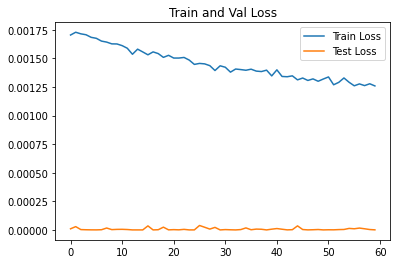

In [129]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

Text(0.5, 1.0, 'Train Data')

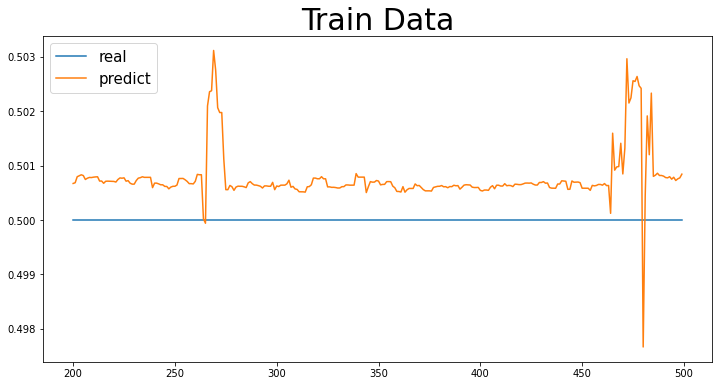

In [130]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

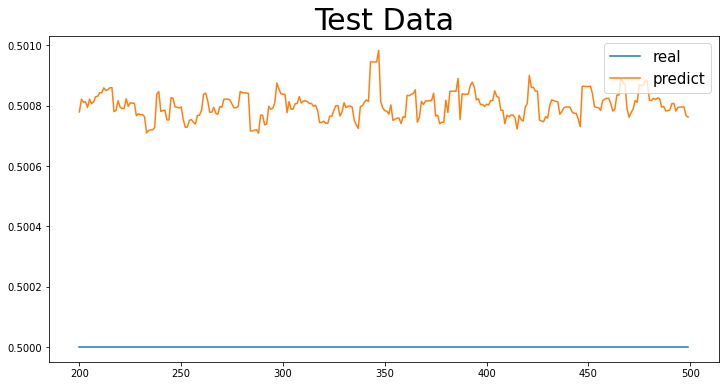

In [131]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [132]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.00881043050028927
0.001016570216000783
2.2846547840639797
0.06273956021787372
测试集上的MAE/MSE/MAPE/涨跌准确率
0.0008068182494392117
6.530325097571023e-07
0.1611028604072002
0.05754088431253786
